In [1]:
import sys
sys.path.append('.')
import anndata
import time, os, sys

import pandas as pd
import glob
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import numpy as np
import scimap as sm
import seaborn as sns
import matplotlib.pyplot as plt

Running SCIMAP  2.2.11


# Create environment with
conda create -n scimap_env python=3.10 jupyter=1.1.1 pip -c conda-forge -c defaults
conda activate scimap_env
pip install git+https://github.com/SchapiroLabor/scimap_COZI.git

In [2]:
# Load in dataset. This is a .csv file with all samples concatenated together, either for symmetric or asymmetric data
path_to_csv = './tutorial_data/'
output_path_COZI_NEP = './../../tutorial_output_COZI.csv'

In [8]:

# read in all csv files in the example data (they all have ct, x and y coordinates) give them a new sample id column of their file names and row bind them all to one big dataframe
csv_files = glob.glob(os.path.join(path_to_csv, '*.csv'))

# Initialize an empty list to store individual DataFrames
data_frames = []

# Loop through the CSV files and process each one
for file in csv_files:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file)
    sample_id = os.path.splitext(os.path.basename(file))[0]
    df['sample_id'] = sample_id
    data_frames.append(df)
    
# Concatenate all DataFrames into one big DataFrame
obs = pd.concat(data_frames, ignore_index=True)
obs

,x,y,ct,sample_id
0,0.00,0.00,1.00,ran_ab0_0.25_1
1,20.92,0.00,1.00,ran_ab0_0.25_1
2,44.38,0.00,0.00,ran_ab0_0.25_1
3,69.77,0.00,3.00,ran_ab0_0.25_1
4,96.62,0.00,2.00,ran_ab0_0.25_1
...,...,...,...,...
16093,22.53,468.98,2.00,self00_0.6_ab0_0.25_2
16094,939.06,247.90,2.00,self00_0.6_ab0_0.25_2
16095,385.69,814.39,3.00,self00_0.6_ab0_0.25_2
16096,657.91,543.04,2.00,self00_0.6_ab0_0.25_2


In [9]:
# create anndata object, randomly initialize marker values for this simulated dataset to comply with anndata format. Otehrwise use true markers for X

obs['D'] = np.random.randint(1, 101, size=len(obs))
obs['E'] = np.random.randint(1, 101, size=len(obs))

# Load dataframe into anndata object
# dataframe for annotating the observations
obs = obs.astype({'ct':'string'})

# the data matrix 
X = obs[['D', 'E']]
X = X.values
adata = anndata.AnnData(X)
adata.obs = obs

adata.obs

,x,y,ct,sample_id,D,E
0,0.00,0.00,1.0,ran_ab0_0.25_1,55,36
1,20.92,0.00,1.0,ran_ab0_0.25_1,75,39
2,44.38,0.00,0.0,ran_ab0_0.25_1,56,61
3,69.77,0.00,3.0,ran_ab0_0.25_1,17,16
4,96.62,0.00,2.0,ran_ab0_0.25_1,38,59
...,...,...,...,...,...,...
16093,22.53,468.98,2.0,self00_0.6_ab0_0.25_2,24,77
16094,939.06,247.90,2.0,self00_0.6_ab0_0.25_2,59,54
16095,385.69,814.39,3.0,self00_0.6_ab0_0.25_2,39,71
16096,657.91,543.04,2.0,self00_0.6_ab0_0.25_2,26,69


In [10]:
# run spatial interaction function in the COZI configuration with conditional normalization to look at neighbor preferences of phenotypes
# INFO: Changing normalization to 'total' runs spatial enrichment analysis (SEA). For running the original scimap spatial_interaction function, 
# create an environment based on the original scimap and run this function without the normalization parameter and run with knn or radius, or 
# check the delauany graph implementation in './../scripts/spatial_interaction_delaunay.py'.
# NEW: We added a new parameter for thresholding the minimum number of conditional cells to normalize with (cells with at least one neighbor of the other cell type). Default is 5.
sm.tl.spatial_interaction(adata, 
                          phenotype='ct', 
                          x_coordinate='x', y_coordinate='y', 
                          imageid='sample_id', 
                          permutation = 300,
                          method='delaunay',
                          verbose=True,
                          normalization = 'conditional',
                          pval_method = 'zscore',
                          cond_counts_threshold = 10,
                          label='delauany_cozi')

Processing Image: ['ran_ab0_0.25_1']
Performing Delaunay triangulation to identify neighbours for every cell
Mapping phenotype to neighbors
Performing 300 permutations
Consolidating the permutation results
Processing Image: ['ran_ab0_0.25_3']
Performing Delaunay triangulation to identify neighbours for every cell
Mapping phenotype to neighbors
Performing 300 permutations
Consolidating the permutation results
Processing Image: ['ran_ab0_0.25_2']
Performing Delaunay triangulation to identify neighbours for every cell
Mapping phenotype to neighbors
Performing 300 permutations
Consolidating the permutation results
Processing Image: ['self00_0.45_ab0_0.25_3']
Performing Delaunay triangulation to identify neighbours for every cell
Mapping phenotype to neighbors
Performing 300 permutations
Consolidating the permutation results
Processing Image: ['self00_0.45_ab0_0.25_2']
Performing Delaunay triangulation to identify neighbours for every cell
Mapping phenotype to neighbors
Performing 300 permu

AnnData object with n_obs × n_vars = 16098 × 2
    obs: 'x', 'y', 'ct', 'sample_id', 'D', 'E'
    uns: 'delauany_cozi'

In [11]:
# create output dataframe of all interactions and samples
save_df = adata.uns['delauany_cozi']
# Convert 'phenotype' and 'neighbour_phenotype' columns to string types
save_df['phenotype'] = save_df['phenotype'].astype(str)
save_df['neighbour_phenotype'] = save_df['neighbour_phenotype'].astype(str)

# Combine 'phenotype' and 'neighbour_phenotype' into 'new_column'
save_df['interaction'] = save_df['phenotype'] + "_" + save_df['neighbour_phenotype']
save_df = save_df.drop(columns=['phenotype', 'neighbour_phenotype'])
save_df = save_df.set_index('interaction')

# Transpose the dataframe and only extract z-scores
save_df_transposed = save_df.transpose()
save_df_transposed.columns = save_df_transposed.columns.str.replace(r"\.0",
                                                                    "",
                                                                    regex=True)
save_df_transposed = save_df_transposed[~save_df_transposed.index.str.contains('pvalue')]
save_df_transposed = save_df_transposed[~save_df_transposed.index.str.contains('count')]
save_df_transposed.index = save_df_transposed.index.str.replace(r"zscore_", "", regex=True)

# View the transposed dataframe (optional)
save_df_transposed
# save the dataframe as csv
#save_df_transposed.to_csv(output_path_COZI_NEP, index=True)

interaction,0_0,0_1,0_2,0_3,1_0,1_1,1_2,1_3,2_0,2_1,2_2,2_3,3_0,3_1,3_2,3_3
ran_ab0_0.25_1,1.88,0.38,-0.62,-1.13,-0.33,0.21,1.68,0.09,-0.40,0.19,-0.07,0.32,-1.40,0.34,0.12,2.97
ran_ab0_0.25_3,-0.67,0.53,-0.58,-0.74,1.83,-0.52,-2.59,-0.01,-0.57,-1.70,-0.02,-0.80,-1.22,0.38,0.70,0.81
ran_ab0_0.25_2,0.23,-1.74,-0.25,1.15,-2.05,0.30,-0.37,0.41,-0.30,0.95,-1.39,-0.61,1.44,-0.96,1.07,-1.77
self00_0.45_ab0_0.25_3,5.54,-0.62,-3.47,-0.31,0.40,-2.30,2.11,2.17,0.11,1.94,0.63,0.81,1.04,0.12,0.19,0.95
self00_0.45_ab0_0.25_2,7.60,-1.68,-3.13,-0.81,0.81,-0.27,2.61,0.06,-0.09,1.47,3.58,0.16,1.29,-1.71,0.92,1.83
self00_0.45_ab0_0.25_1,7.41,-1.45,-1.58,-0.82,-0.11,2.08,-0.96,0.99,3.64,1.89,1.47,0.88,0.80,2.03,0.56,-0.69
self00_0.6_ab0_0.25_1,15.79,-2.91,-3.99,-1.70,3.16,3.13,2.35,1.85,0.55,2.36,3.98,0.14,-0.80,0.44,1.58,2.63
self00_0.6_ab0_0.25_3,13.42,-2.39,-1.83,-2.55,-1.63,0.47,2.04,2.37,-0.92,1.93,1.76,-0.31,2.44,0.80,0.11,-1.19
self00_0.6_ab0_0.25_2,18.01,-0.95,-3.60,-1.54,1.46,3.84,1.58,1.11,-1.52,-0.97,3.76,3.08,-0.80,1.50,2.21,0.16


<Axes: xlabel='interaction'>

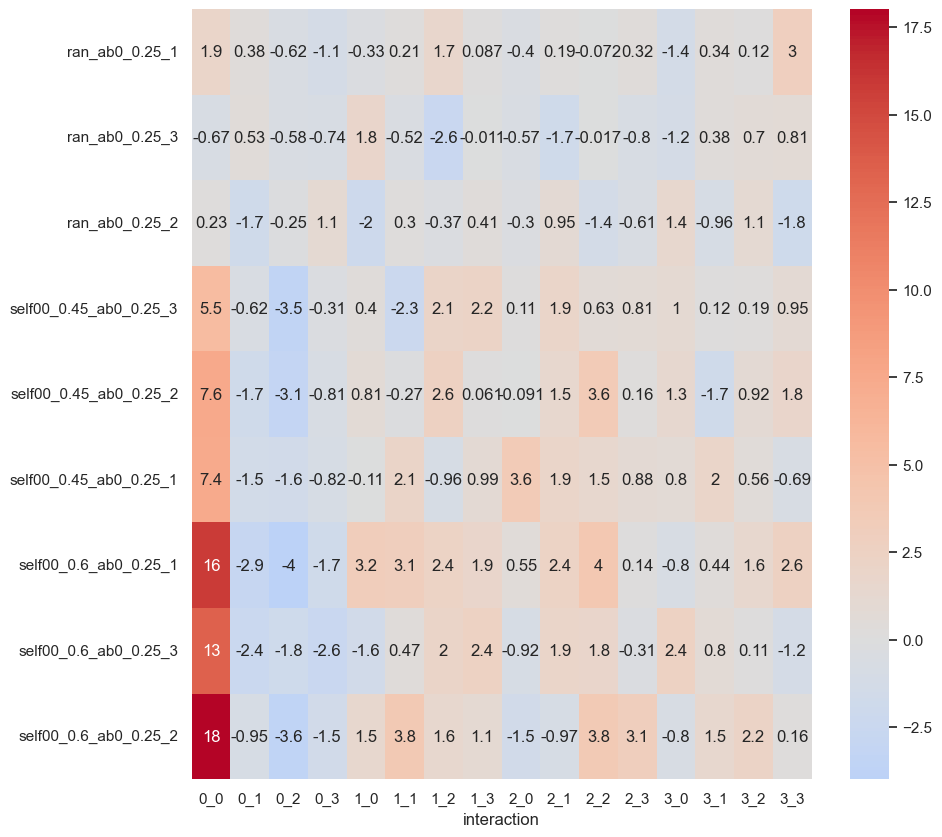

In [12]:
# make a heatmap of the interactions in save_df_transposed
plt.figure(figsize=(10, 10))
sns.heatmap(save_df_transposed, cmap='coolwarm', center=0, annot=True)

One can see the differences in the NEP scores in the random (ran), weak (self00_0.45) and strong (self00_0.6) simulated cohorts of the self interaction of cell type '0'. 